In [1]:
import matplotlib.pyplot as plt
from datasets.PupilCoreDatasetIfOpened import PupilCoreDatasetIfOpened
from datasets.PupilCoreDatasetPupil import PupilCoreDatasetPupil
from datasets.PupilCoreDatasetCornealReflection import PupilCoreDatasetCornealReflection
from models.ifOpened import ifOpenedModel
from models.pupilDetectModel import PupilDetectModel
from models.utils import train_first_model
import models.utils as utils
import torch
from torch import nn
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy
from torchvision.models.segmentation import FCN_ResNet50_Weights, fcn_resnet50
import numpy as np
import cv2

In [2]:
model = fcn_resnet50(weights=None, num_classes=2)
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [75]:
import torch
from torchvision import transforms
from datasets.utils import get_labels_from_csv, get_frames_from_video
import numpy as np
import cv2
import os


class PupilCoreDatasetPupil(torch.utils.data.Dataset):
    def __init__(
        self, eye0_video_path, eye0_labels_path, eye1_video_path, eye1_labels_path, dataset_len
    ) -> None:
        super().__init__()
        self.eye0_video_path = eye0_video_path
        self.eye0_labels_path = eye0_labels_path
        self.eye1_video_path = eye1_video_path
        self.eye1_labels_path = eye1_labels_path
        self.eye0_labels_df = get_labels_from_csv(self.eye0_labels_path, dataset_len)
        self.eye0_frames = get_frames_from_video(self.eye0_video_path, dataset_len)
        self.eye1_labels_df = get_labels_from_csv(self.eye1_labels_path, dataset_len)
        self.eye1_frames = get_frames_from_video(self.eye1_video_path, dataset_len)
        self.dataset_len = dataset_len
        self.eye0_masks = []
        self.eye1_masks = []

    def load_masks(self, eye0_path, eye1_path):
        # self.eye1_masks = []
        # self.eye0_masks = []
        for file in os.listdir(eye0_path)[:self.dataset_len]:
            
            mask = cv2.imread(f"{eye0_path}/{file}", cv2.IMREAD_GRAYSCALE)
            self.eye0_masks.append(mask)

        for file in os.listdir(eye1_path)[:self.dataset_len]:
            mask = cv2.imread(f"{eye1_path}/{file}", cv2.IMREAD_GRAYSCALE)
            self.eye1_masks.append(mask)

    def get_pupil_ellipse(self):
        self.eye0_masks = []
        self.eye1_masks = []
        for i, image in enumerate(self.eye0_frames):
            pupil_center = np.array(
                [
                    int(self.eye0_labels_df.at[i, "pupil_center_x_coord"]),
                    int(self.eye0_labels_df.at[i, "pupil_center_y_coord"]),
                ]
            )
            pupil_axes = (
                int(self.eye0_labels_df.at[i, "pupil_axis_1"] // 2),
                int(self.eye0_labels_df.at[i, "pupil_axis_2"] // 2),
            )
            mask = np.zeros(image.shape)
            ellipse = cv2.ellipse(
                    img=mask,
                    center=pupil_center,
                    axes=pupil_axes,
                    angle=self.eye0_labels_df.at[i, "elipse_angle"],
                    startAngle=0,
                    endAngle=360,
                    color=(255, 255, 255),
                    thickness=-1,
                )
            ellipse = np.asarray(ellipse, dtype=np.float32)
            ellipse = cv2.cvtColor(ellipse, cv2.COLOR_RGB2GRAY)
            ret, b_ellipse = cv2.threshold(ellipse, 1, 1, cv2.THRESH_BINARY)
            self.eye0_masks.append(
                b_ellipse
            )

        for i, image in enumerate(self.eye1_frames):
            pupil_center = np.array(
                [
                    int(self.eye1_labels_df.at[i, "pupil_center_x_coord"]),
                    int(self.eye1_labels_df.at[i, "pupil_center_y_coord"]),
                ]
            )
            pupil_axes = (
                int(self.eye1_labels_df.at[i, "pupil_axis_1"] // 2),
                int(self.eye1_labels_df.at[i, "pupil_axis_2"] // 2),
            )
            mask = np.zeros(image.shape)
            ellipse = cv2.ellipse(
                    img=mask,
                    center=pupil_center,
                    axes=pupil_axes,
                    angle=self.eye1_labels_df.at[i, "elipse_angle"],
                    startAngle=0,
                    endAngle=360,
                    color=(255, 255, 255),
                    thickness=-1,
                )
            ellipse = np.asarray(ellipse, dtype=np.float32)
            ellipse = cv2.cvtColor(ellipse, cv2.COLOR_RGB2GRAY)
            ret, b_ellipse = cv2.threshold(ellipse, 1, 1, cv2.THRESH_BINARY)
            self.eye1_masks.append(
                b_ellipse
            )

    def save_masks(self, path):
        for i, mask in enumerate(self.eye0_masks):
            
            cv2.imwrite(f"{path}/eye0/{i}.png", mask)

        for i, mask in enumerate(self.eye1_masks):

            cv2.imwrite(f"{path}/eye1/{i}.png", mask)

    # ================= for pupil segmentation ===================
    def __getitem__(self, idx):
        image = self.eye0_frames[idx]
        pupil_mask = self.eye0_masks[idx]

        T = transforms.Compose([transforms.ToTensor()])
        image = T(image)
        pupil_mask = T(pupil_mask)

        return image, pupil_mask

    # ================ for pupil core =======================
    # def __getitem__(self, idx):
    #     pupil_coords = np.array(
    #         [
    #             self.eye0_labels_df.at[idx, "pupil_center_x_coord"],
    #             self.eye0_labels_df.at[idx, "pupil_center_y_coord"],
    #         ]
    #     )
    #     image = self.eye0_frames[idx]
    #     T = transforms.Compose([transforms.ToTensor()])
    #     image = T(image)
    #     pupil_coords = torch.as_tensor(pupil_coords, dtype=torch.float32)
    #     return image, pupil_coords

    def __len__(self):
        return len(self.eye0_frames)


In [76]:
DATASET_LEN_TO_USE = 1
dataset_pupil = PupilCoreDatasetPupil(
    "datasets/PupilCoreDataset/video5_eye0_video.avi",
    'datasets/PupilCoreDataset/video5_eye0_pupildata.csv',
    "datasets/PupilCoreDataset/video5_eye1_video.avi",
    'datasets/PupilCoreDataset/video5_eye1_pupildata.csv',
    DATASET_LEN_TO_USE
)
dataset_pupil.get_pupil_ellipse()


UnboundLocalError: local variable 'b_ellipse' referenced before assignment

In [77]:
dataset_pupil.save_masks("datasets/PupilCoreDataset/created_masks")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

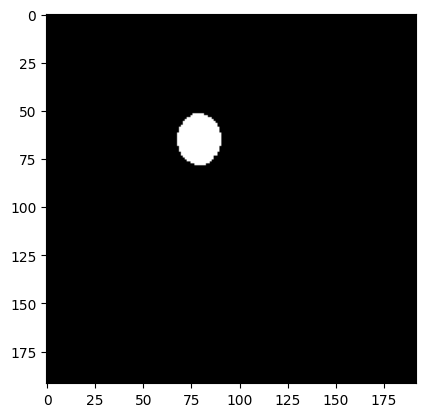

In [74]:
dataset_pupil.load_masks("datasets/PupilCoreDataset/created_masks/eye0", "datasets/PupilCoreDataset/created_masks/eye1")
plt.imshow(dataset_pupil.eye0_masks[0],cmap='gray')
for i in dataset_pupil.eye0_masks[0]:
    print(i)

# for i in range(10):
        
#     image = np.transpose((train_dataset[i])[1].numpy(), (1, 2, 0)).copy()
#     plt.imshow(image)
#     plt.show()
#     image = np.transpose((train_dataset[i])[0].numpy(), (1, 2, 0)).copy()
#     plt.imshow(image)
#     plt.show()

In [64]:
train_part = int(DATASET_LEN_TO_USE * 0.8)
train_part = DATASET_LEN_TO_USE - train_part
print(len(dataset_pupil))
indices = torch.randperm(len(dataset_pupil)).tolist()
# print(indices)
train_set = torch.utils.data.Subset(dataset_pupil, indices[:80])
test_set = torch.utils.data.Subset(dataset_pupil, indices[80:])
print(len(train_set))

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
print(len(train_dataloader))
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

1
1
1


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:


def train(model, num_epochs):
    model = model.to(device)
    model.train()
    for epoch in range(num_epochs):

        for i, (inputs, mask) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            mask = mask.to(device)
            
            # optimizer.zero_grad()

            outputs = model(inputs)
            # print(outputs['out'].shape)
            pred = outputs['out'].softmax(dim=1)
            print(pred)
            pred = pred.to(device)




In [ ]:
# train_dataloader
train(model, 1)

tensor([[[[0.6967, 0.6967, 0.6967,  ..., 0.5602, 0.5602, 0.5602],
          [0.6967, 0.6967, 0.6967,  ..., 0.5602, 0.5602, 0.5602],
          [0.6967, 0.6967, 0.6967,  ..., 0.5602, 0.5602, 0.5602],
          ...,
          [0.4678, 0.4678, 0.4678,  ..., 0.6180, 0.6180, 0.6180],
          [0.4678, 0.4678, 0.4678,  ..., 0.6180, 0.6180, 0.6180],
          [0.4678, 0.4678, 0.4678,  ..., 0.6180, 0.6180, 0.6180]],

         [[0.3033, 0.3033, 0.3033,  ..., 0.4398, 0.4398, 0.4398],
          [0.3033, 0.3033, 0.3033,  ..., 0.4398, 0.4398, 0.4398],
          [0.3033, 0.3033, 0.3033,  ..., 0.4398, 0.4398, 0.4398],
          ...,
          [0.5322, 0.5322, 0.5322,  ..., 0.3820, 0.3820, 0.3820],
          [0.5322, 0.5322, 0.5322,  ..., 0.3820, 0.3820, 0.3820],
          [0.5322, 0.5322, 0.5322,  ..., 0.3820, 0.3820, 0.3820]]],


        [[[0.7505, 0.7505, 0.7505,  ..., 0.5700, 0.5700, 0.5700],
          [0.7505, 0.7505, 0.7505,  ..., 0.5700, 0.5700, 0.5700],
          [0.7505, 0.7505, 0.7505,  ...,